In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa

from sklearn.feature_extraction.text import CountVectorizer  ## BOW Model
from sklearn.feature_extraction.text import TfidfVectorizer  ## TFIDF Model

from sklearn.naive_bayes import BernoulliNB      #Bernoulli NB
from sklearn.naive_bayes import MultinomialNB    #Multinomial NB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
conn = sqlite3.connect('final3.sqlite')  #Loading the sqlite file for future use
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedNoStem,CleanedSummary
0,540125,B002W08W56,A2STPOZAT37RNE,Betty Baker,1,1,1,1300320000,"Wonderful, but surprised to find this size can...",Great beans....the best texture hands down. T...,great bean best textur hand seem great tast do...,great beans best texture hands seem great tast...,wonderful surprised find size
1,31763,B000UXWQMC,A115Y8R40DCT3I,Guy,0,0,1,1345161600,better than expected,I usually buy whole pitted olives and when I b...,usual buy whole pit oliv bought good wasnt who...,usually buy whole pitted olives bought good wa...,better expected
2,509504,B000P09RJA,A2BR8LGC8N6XQD,dj2u,0,4,0,1278374400,Wrong size bars sent,The first shipment was just as ordered. This ...,first shipment order last shipment not bar wen...,first shipment ordered last shipment not bars ...,wrong size bars sent
3,27728,B000K8ESBY,A1RYTIMIWPDJ4O,"Bill Ison ""Bill""",0,0,1,1256169600,Coffee flavoring,"<a href=""http://www.amazon.com/gp/product/B000...",flavour creation coffe flavor tablet french va...,flavour creations coffee flavoring tablets fre...,coffee flavoring
4,128657,B001AVJT0K,AJ6SZ4YAPOOO7,Mwebi,0,0,1,1348099200,They all come running,"I have the pickiest cats, they hate 99/100 kin...",pickiest cat hate kind food better vari otherw...,pickiest cats hate kinds food better vary othe...,come running


In [3]:
negative = final[final['Score']==0][['Score','Time','CleanedSummary','CleanedText']]
positive = final[final['Score']==1][['Score','Time','CleanedSummary','CleanedText']]
data = pd.concat([negative,positive.iloc[:67000,:]],axis=0,ignore_index = True)
data.sort_values('Time',inplace = True)
data.head(10)

,Score,Time,CleanedSummary,CleanedText
89279,1,944092800,entertainingl funny,beetlejuic well written movi everyth excel act...
99092,1,944438400,modern day fairy tale,twist rumplestiskin captur film star michael k...
21840,0,948240000,clamshell edition edited version,alway enjoy movi funni entertain didnt hesit p...
114632,1,951523200,bettlejuice bettlejuice bettlejuice,happen say name three time michael keaten star...
113134,1,961718400,great product,realli good idea final product outstand use de...
64542,1,965779200,must,easi use not make mess offer vibrant color not...
88945,1,966297600,fresh original film master storyteller tim burton,great film dont even know sum first complet or...
76537,1,975974400,needs wilton,sick scad nasti toothpick counter tint concept...
50919,0,992217600,casper ghost,michael keaton bring distinguish characterist ...
8665,0,997228800,great movie terrible dvd,continu amaz shoddi treatment movi get dvd rel...


In [13]:
data['Score'].value_counts()

1    67000
0    57110
Name: Score, dtype: int64

# Bernoulli Naive - Bayes using Binary BoW

In [14]:
bow_vect = CountVectorizer(binary = True)
bow = bow_vect.fit_transform(data['CleanedText'].values)

In [15]:
X = bow
y = data['Score'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is0.2.


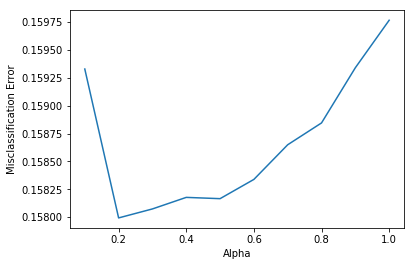

In [20]:
alpha = np.linspace(0.1,1,10)
cv_score = []

for a in alpha:
    clf = BernoulliNB(alpha = a)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [23]:
clf = BernoulliNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print(acc)
confusion_matrix(y_test,y_pred).T

83.6301130717


array([[14612,  2423],
       [ 3672, 16526]], dtype=int64)

In [24]:
idx = (-clf.feature_log_prob_).argsort()[:2, :50]
print('Top 50 words in negative reviews')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])
    
print('\n******************************\n')
print('Top 50 words in positive reviews')
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])

Top 50 words in negative reviews
not
tast
like
product
one
would
tri
flavor
good
buy
get
use
dont
even
order
much
make
realli
time
amazon
love
look
eat
box
disappoint
bought
food
purchas
review
first
better
packag
want
bad
think
coffe
also
bag
could
know
say
well
great
didnt
thought
price
give
made
way
got

******************************

Top 50 words in positive reviews
not
like
tast
love
good
great
flavor
one
use
tri
product
make
get
time
buy
would
realli
amazon
find
best
also
price
much
eat
dont
littl
store
well
order
food
even
coffe
ive
better
recommend
year
tea
day
found
high
drink
mix
sweet
give
bag
first
delici
want
enjoy
favorit


# Multinomial Naive Bayes using BoW

In [22]:
bow_vect = CountVectorizer()
bow = bow_vect.fit_transform(data['CleanedText'].values)

In [23]:
X = bow
y = data['Score'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is1.0.


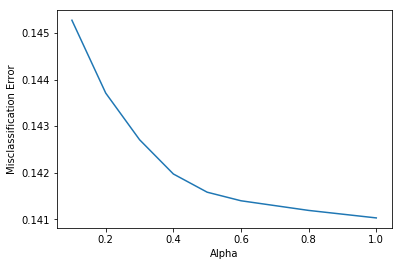

In [25]:
alpha = np.linspace(0.1,1,10)
cv_score = []

for a in alpha:
    clf = MultinomialNB(alpha = a)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [28]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print(acc)
confusion_matrix(y_test,y_pred).T

85.6713130825


array([[15405,  2456],
       [ 2879, 16493]], dtype=int64)

In [29]:
idx = (-clf.feature_log_prob_).argsort()[:2, :50]
print('Top 50 words in negative reviews')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])
    
print('\n******************************\n')
print('Top 50 words in positive reviews')
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])

Top 50 words in negative reviews
not
tast
like
product
one
flavor
would
tri
good
coffe
use
get
buy
order
food
tea
dont
box
even
amazon
make
much
bag
time
eat
realli
look
love
packag
review
purchas
dog
bought
first
disappoint
bad
chocol
better
want
also
price
think
know
could
made
water
say
didnt
drink
sugar

******************************

Top 50 words in positive reviews
not
like
tast
good
flavor
love
great
use
one
product
tri
tea
coffe
make
get
food
time
would
buy
realli
eat
amazon
find
also
price
best
much
dont
littl
order
well
store
ive
drink
bag
even
mix
dog
chocol
better
year
day
recommend
sweet
sugar
box
found
high
water
first


# Multinomial Naive Bayes using TF - IDF

In [30]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(data["CleanedText"].values)
tf_idf.shape

(124110, 42538)

In [31]:
X = tf_idf
y = data['Score'].values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is0.5.


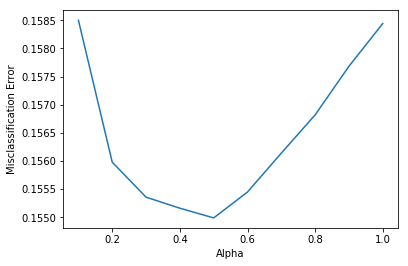

In [33]:
alpha = np.linspace(0.1,1,10)
cv_score = []

for a in alpha:
    clf = MultinomialNB(alpha = a)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [34]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print(acc)
confusion_matrix(y_test,y_pred).T

84.0517820213


array([[14150,  1804],
       [ 4134, 17145]], dtype=int64)

In [35]:
idx = (-clf.feature_log_prob_).argsort()[:2, :50]
print('Top 50 words in negative reviews')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])
    
print('\n******************************\n')
print('Top 50 words in positive reviews')
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])

Top 50 words in negative reviews
not
tast
like
product
flavor
coffe
one
would
tri
buy
order
tea
good
box
get
dont
use
disappoint
even
food
amazon
bag
much
eat
realli
bad
purchas
packag
bought
chocol
look
time
dog
review
price
make
didnt
money
item
better
receiv
love
want
thought
smell
think
first
could
got
know

******************************

Top 50 words in positive reviews
great
love
good
tea
tast
flavor
like
coffe
not
use
product
one
tri
make
best
price
get
find
amazon
food
buy
realli
time
order
store
eat
dog
littl
much
drink
would
ive
also
chocol
well
mix
delici
better
recommend
bag
dont
year
favorit
treat
sweet
snack
day
enjoy
high
nice
